### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [54]:
!pip install pycbc #installing required package

In [55]:
%matplotlib inline
from pycbc.catalog import Merger
from pycbc import psd
from pycbc.psd import read, analytical
import pylab
import matplotlib.pyplot as plt
import numpy as np

In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [56]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [57]:
print("number of data points is:", len(data.sample_times))
print("the sampling rate is:", data.sample_rate)
print("the duration is:", data.duration)
print("the delt f is:", 1/data.duration)
print("the delt t is:", 1/data.sample_rate)

N=1/(data.delta_f *data.delta_t)
print("the number of data points is:", N) #this matches the number expected, as found above

number of data points is: 131072
the sampling rate is: 4096.0
the duration is: 32.0
the delt f is: 0.03125
the delt t is: 0.000244140625
the number of data points is: 131072.0


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

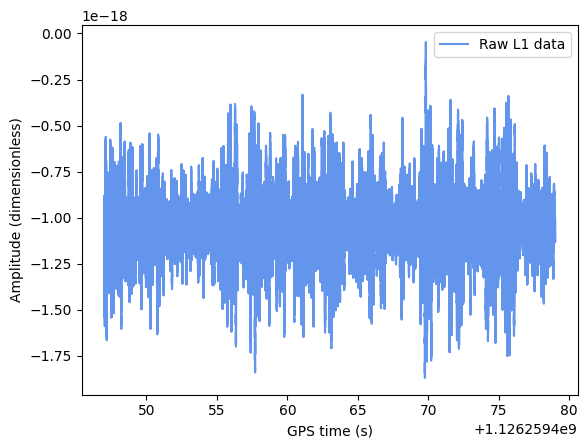

In [58]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

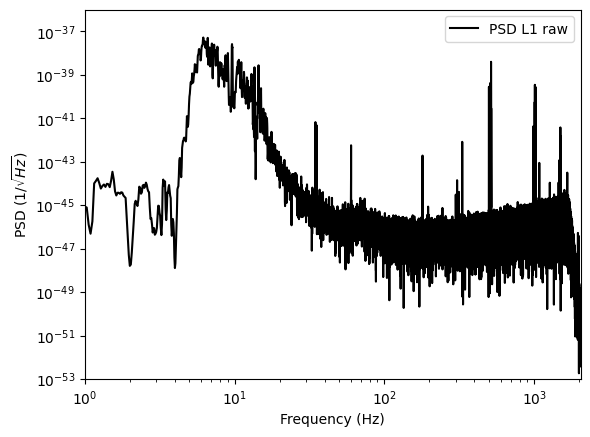

In [59]:
delta_f = 1/data.duration
flow = 1
psd = data.filter_psd(data.duration, delta_f, flow)
frequencies = np.arange(len(psd)) * delta_f
plt.plot(frequencies, psd, color='black', label="PSD L1 raw") #plotting this psd
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($1/\sqrt{Hz}$)')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1, data.sample_rate/2) #limiting frequencies
plt.ylim(10**-53, 10**-36)
plt.legend()
plt.show()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


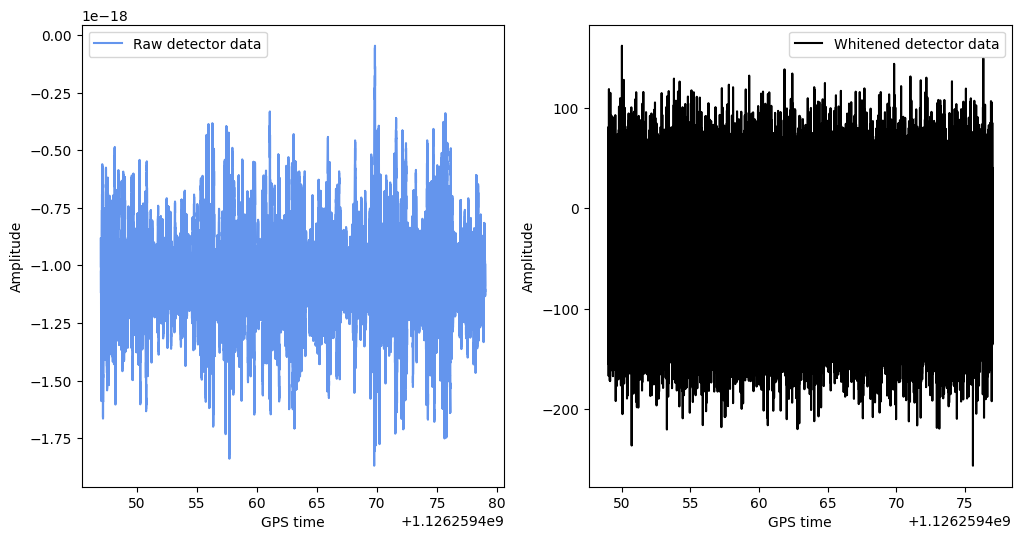

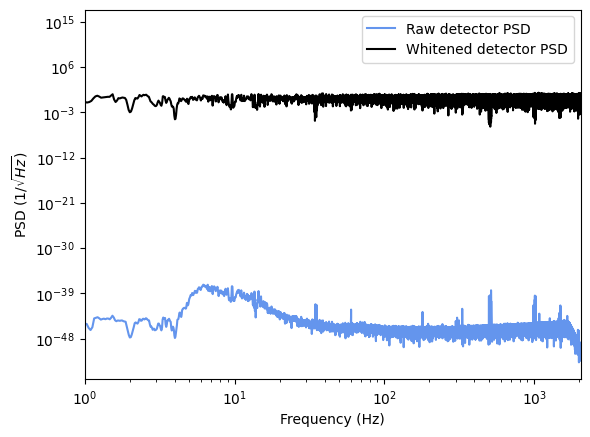

In [60]:
segment_duration = 4
max_filter_duration=4
whitened_data = data.whiten(segment_duration, max_filter_duration) #whitening data
psd_whitened = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow=1) #finding PSD for the whitened data

fig=plt.figure(figsize=(12,6)) # plotting whitened next to raw data

plt.subplot(1,2,1)
plt.plot(data.sample_times, data, color='cornflowerblue', label="Raw detector data")
plt.xlabel('GPS time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1,2,2)
plt.plot(whitened_data.sample_times, whitened_data, color='black', label="Whitened detector data")
plt.xlabel('GPS time')
plt.ylabel('Amplitude')

plt.legend()
plt.show()

plt.loglog(psd.get_sample_frequencies(), psd, color='cornflowerblue', label="Raw detector PSD")
plt.loglog(psd_whitened.get_sample_frequencies(), psd_whitened, color='black', label="Whitened detector PSD")
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($1/\sqrt{Hz}$)')
plt.xlim(1, max(frequencies))
plt.legend()

The time series for the whitened data has much higher amplitudes than the raw data. It is appears to have been stretch to make it a more uniform block with similar amplitudes across all time. The PSD for the whitened data is a much straighter, flatter line. This makes sense, as the whitened data now has much more similar amplitudes across time. It also shows much higher values for the strength of the signal, correlating to the high amplitude values in the time series.

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

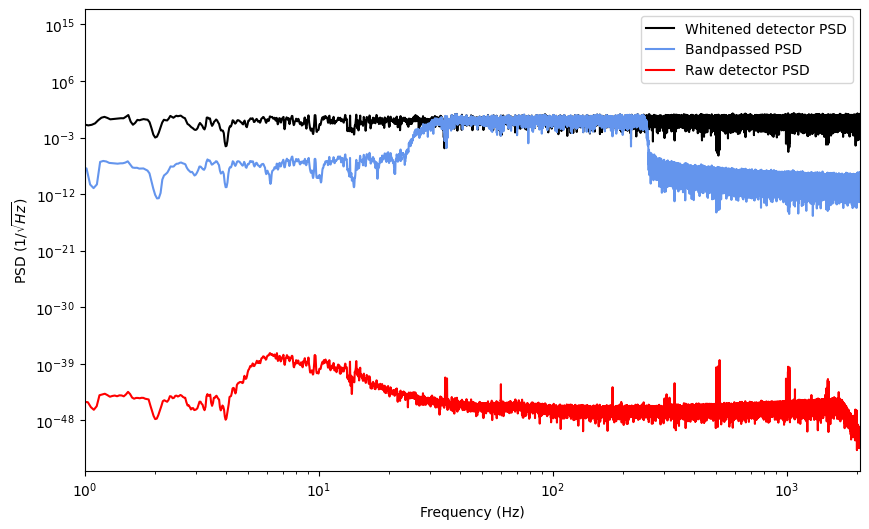

In [61]:
high_pass_filter = whitened_data.highpass_fir(frequency=30, order=512, beta=5.0, remove_corrupted=True) #applying high pass first
bandpassed_data = high_pass_filter.lowpass_fir(frequency=250, order=512, beta=5.0, remove_corrupted=True) #now applying low pass
psd_bandpassed = bandpassed_data.filter_psd(bandpassed_data.duration, bandpassed_data.delta_f, flow=1)


fig=plt.figure(figsize=(10,6))
plt.loglog(psd_whitened.get_sample_frequencies(), psd_whitened, color='black', label="Whitened detector PSD")
plt.loglog(psd_bandpassed.get_sample_frequencies(), psd_bandpassed, color='cornflowerblue', label="Bandpassed PSD")

plt.loglog(psd.get_sample_frequencies(), psd, color='red', label="Raw detector PSD")
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($1/\sqrt{Hz}$)')
plt.xlim(1, max(frequencies))
plt.legend()

The bandpassed data is very similar to the whitened data between 30 and 250Hz. Outside of this range, the amplitude is reduced. The bandpass lets frequencies between the range pass through unaffected, but attenuates the frequencies outside of this. This allows noise to be removed, and only keep the frequencies within the range of interest.

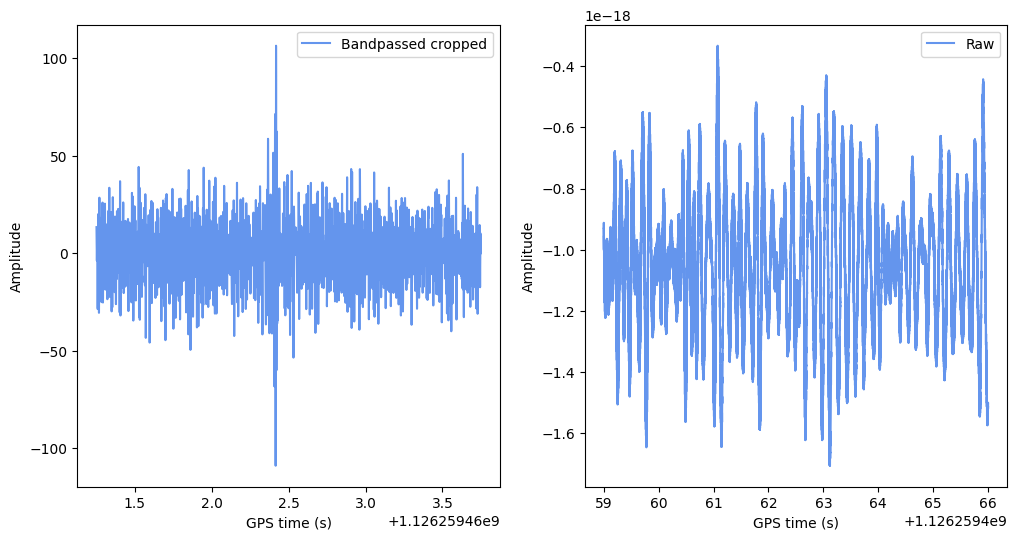

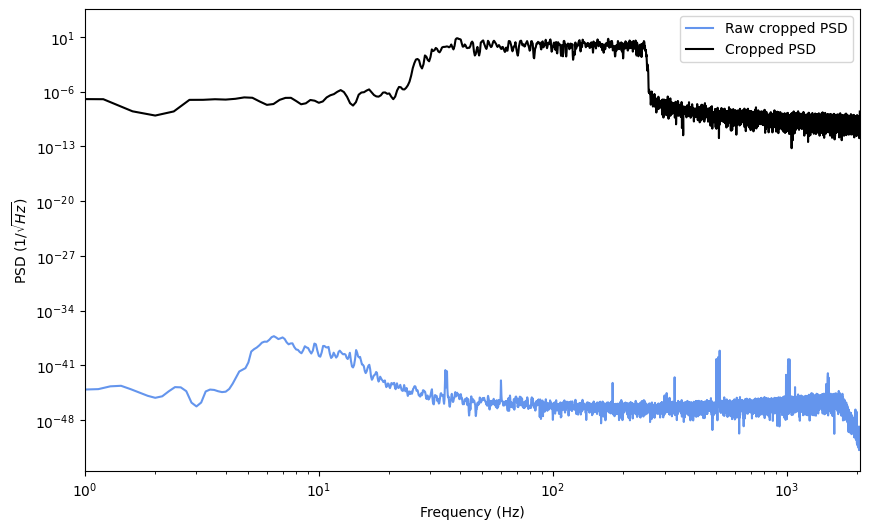

In [62]:
cropped_data = data.crop(12, 13) #cropping origional data
psd_cropped = cropped_data.filter_psd(cropped_data.duration, cropped_data.delta_f, flow=1)

cropped_whitened_data = whitened_data.crop(12, 13) #cropping whitened data
high_pass_filter_cropped = cropped_whitened_data.highpass_fir(frequency=30, order=512, beta=5.0, remove_corrupted=True)
bandpassed_data_cropped = high_pass_filter_cropped.lowpass_fir(frequency=250, order=512, beta=5.0, remove_corrupted=True)#passing it through the bandpass
psd_bandpassed_cropped = bandpassed_data_cropped.filter_psd(bandpassed_data_cropped.duration, bandpassed_data_cropped.delta_f, flow=1)

fig=plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plt.plot(bandpassed_data_cropped.sample_times, bandpassed_data_cropped, color='cornflowerblue', label="Bandpassed cropped")
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cropped_data.sample_times, cropped_data, color='cornflowerblue', label="Raw")
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

fig=plt.figure(figsize=(10,6))
plt.loglog(psd_cropped.get_sample_frequencies(), psd_cropped, color='cornflowerblue', label="Raw cropped PSD")
plt.loglog(psd_bandpassed_cropped.get_sample_frequencies(), psd_bandpassed_cropped, color='black', label="Cropped PSD")
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($1/\sqrt{Hz}$)')
plt.xlim(1, max(frequencies))
plt.legend()
plt.show()

It is clear that the bandpass has removed a lot of the noise. It is now much easier to see the differences in amplitude at different times. The most significant difference happens at around 2.4s into this time frame. Comparing the cropped PSD to the uncropped, the width of the amplitude is reduced, there is less noise, particularly between the bandpassed frequency range.


**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

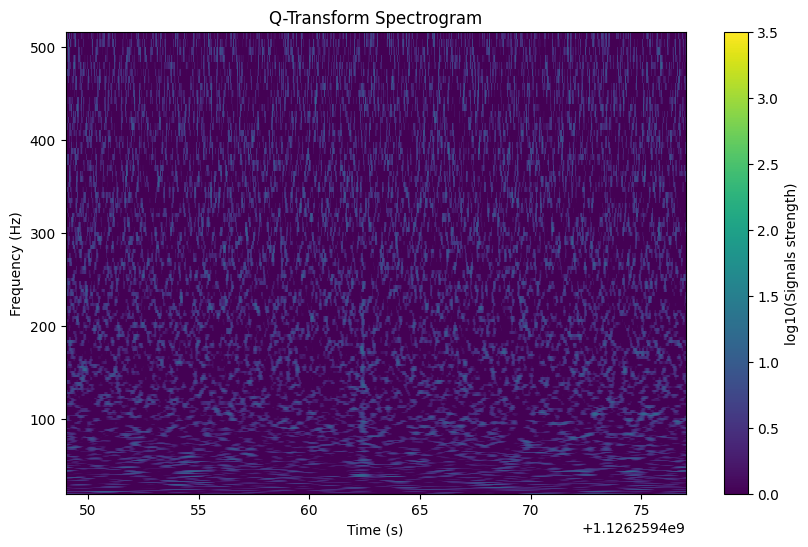

In [63]:
times, frequencies, power = whitened_data.qtransform(delta_t=whitened_data.delta_t, logfsteps=200, frange=(20, 512), qrange=(110, 110))
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.log10(power), shading='auto', cmap='viridis', vmin=0, vmax=3.5) #plotting spectrogram with limits
plt.colorbar(label="log10(Signals strength)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Q-Transform Spectrogram")
plt.show()

There is clearly something around into this data set 63s as there is an unusual bright line from around 0 to 200Hz.

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


In [64]:
low_freq_cutoff = 10
delta_f = 1/16 #1/duration
length =int(8192/(2*delta_f)) #Nyquist frequency​/delta_f, int to make sure it is an integer
L1 = read.from_txt("aligo_O3actual_L1.txt", length, delta_f, low_freq_cutoff, is_asd_file=True)
H1 = read.from_txt("aligo_O3actual_H1.txt", length, delta_f, low_freq_cutoff, is_asd_file=True)
V1 = read.from_txt("avirgo_O3actual.txt", length, delta_f, low_freq_cutoff, is_asd_file=True)
LIGO = read.from_txt("aligo_O4high.txt", length, delta_f, low_freq_cutoff=10.22, is_asd_file=True)#low cuttoff found from opening the data and reading in the first few lines
ET = analytical.EinsteinTelescopeP1600143(length, delta_f, low_freq_cutoff)
Cosmic = analytical.CosmicExplorerP1600143(length, delta_f, low_freq_cutoff)

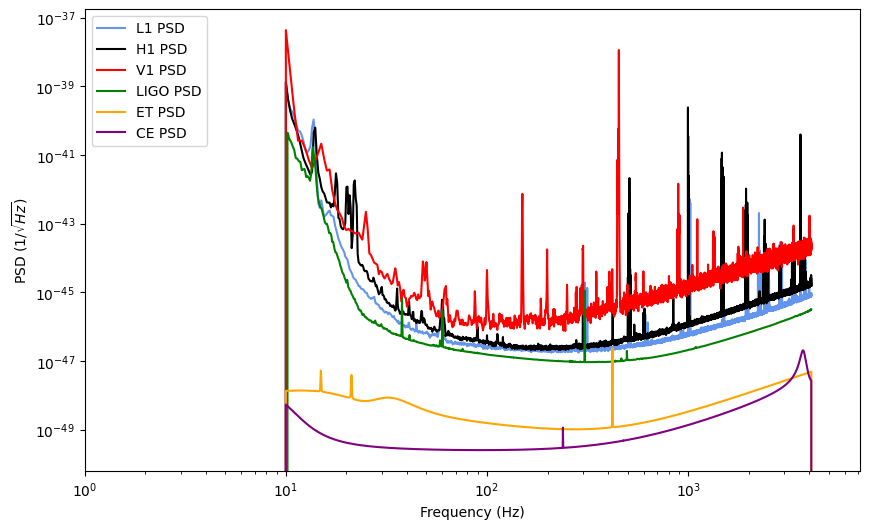

In [65]:
fig=plt.figure(figsize=(10,6))
plt.loglog(L1.get_sample_frequencies(), L1, color='cornflowerblue', label="L1 PSD")
plt.loglog(H1.get_sample_frequencies(), H1, color='black', label="H1 PSD")
plt.loglog(V1.get_sample_frequencies(), V1, color='red', label="V1 PSD")
plt.loglog(LIGO.get_sample_frequencies(), LIGO, color='green', label="LIGO PSD")
plt.loglog(ET.get_sample_frequencies(), ET, color='orange', label="ET PSD")
plt.loglog(Cosmic.get_sample_frequencies(), Cosmic, color='purple', label="CE PSD")
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($1/\sqrt{Hz}$)')
plt.xlim(left=1)
plt.legend()
plt.show()

The PSDs for both the EinsteinTelescope and CosmicExplorer are much cleaner than for the others. The peaks are very well defined, and there are much fewer of them. This makes it easier to see exactly which frequancies have peaks. The values of the strength of the signal is much lower for both of these, suggesting that they are significantly more sensitive.

Good job! This is the end of the second part. Maybe you can go for a break?